## Imports & Data Loading
* data handling (`numpy`)
* model evaluation (`f1_score`, `ConfusionMatrixDisplay`)
* classic ML algorithms (KNN, Logistic Regression, SVM, Decision Tree, Naïve Bayes)
* imbalance handling (`SMOTEENN`)
* plotting (`matplotlib`).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

## Load Embeddings & Labels
Load the pre‑computed 3 × 768 text embeddings for **title, content, hashtags**
and their corresponding labels (`y_*`).
All `.npy` files were generated earlier in the pipeline.

In [2]:
DATA_ROOT = os.path.realpath(os.path.join(os.path.dirname(os.curdir), '..', 'data'))
DATASET_PATH = os.path.join(DATA_ROOT, 'Numpy Data')
X_train = np.load(os.path.join(DATASET_PATH, 'Text', 'X_train_text.npy'))
X_val = np.load(os.path.join(DATASET_PATH, 'Text', 'X_val_text.npy'))
X_test = np.load(os.path.join(DATASET_PATH, 'Text', 'X_test_text.npy'))
y_train = np.load(os.path.join(DATASET_PATH, 'y_train_text.npy'))
y_val = np.load(os.path.join(DATASET_PATH, 'y_val_text.npy'))

In [3]:
# Inspect the data
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (9851, 3, 768)
X_val shape: (100, 3, 768)
X_test shape: (18679, 3, 768)
y_train shape: (9851,)
y_val shape: (100,)


## Merge, Re‑split, and Balance With SMOTEENN
First concatenate the original training and validation sets, then create a fresh 80 / 20 split that keeps label proportions intact (`stratify`).
Because the dataset is imbalanced, I pass the flattened embeddings through **SMOTEENN**, which oversamples the minority class (SMOTE) and removes noisy majority samples (ENN).

In [4]:
X_full  = np.concatenate([X_train, X_val])
y_full  = np.concatenate([y_train, y_val])
X_tr, X_va, y_tr, y_va = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

In [5]:
sampler = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_tr.reshape(len(X_tr), -1), y_tr)
X_val_resampled, y_val_resampled = sampler.fit_resample(X_va.reshape(len(X_va), -1), y_va)

## Define Baseline Model Zoo
Create a dictionary of five classic ML models with mostly default hyper‑parameters.

In [6]:
models = {
    'KNN'              : KNeighborsClassifier(n_neighbors=5),
    'LogisticRegression': LogisticRegression(max_iter=300, n_jobs=-1),
    'SVM'              : SVC(kernel='rbf', probability=True),
    'DecisionTree'     : DecisionTreeClassifier(random_state=42),
    'NaiveBayes'       : GaussianNB()
}

### Training Loop & Macro‑F1 Collection
Fit each model on the **balanced** training set and evaluate it on the balanced validation set.
The metric is **macro‑averaged F1**, which gives equal weight to each class regardless of prevalence.

In [7]:
f1_scores = {}
for name, clf in models.items():
    clf.fit(X_train_resampled, y_train_resampled)
    preds = clf.predict(X_val_resampled)
    f1_scores[name] = f1_score(y_val_resampled, preds, average='macro')

### Plot Baseline F1 Scores
Visualise the macro‑F1 results for all five models.
The numeric labels above each bar highlight exact values for quick comparison.

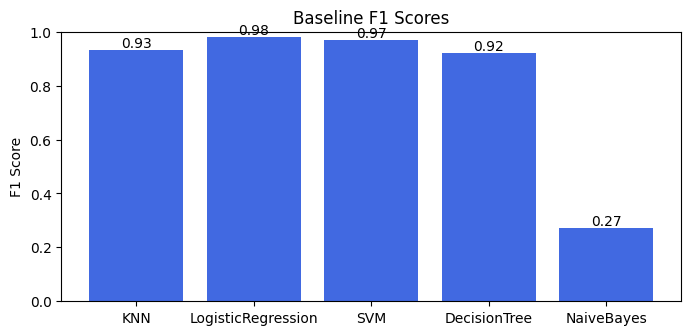

In [ ]:
plt.figure(figsize=(8,3.5))
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color='royalblue')
plt.ylim(0,1); plt.ylabel('F1 Score'); plt.title('Baseline F1 Scores')
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+.01,
             f'{b.get_height():.2f}', ha='center')
plt.savefig(os.path.join("Results", 'baseline_f1_scores.png'), bbox_inches='tight')
plt.show()

### Select Best Model & Show Confusion Matrix
Pick the model with the highest validation F1, re‑fit it on **all** balanced training examples, and evaluate it on the untouched test set.
The confusion matrix reveals class‑wise performance, making it easy to spot remaining false positives/negatives.

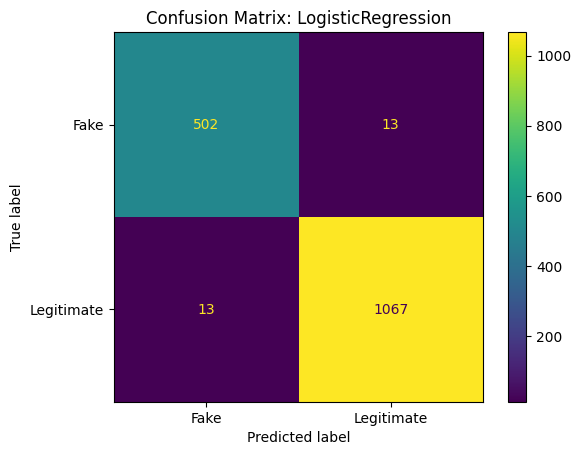

Accuracy: 0.9837
Precision: 0.9814
Recall: 0.9814
Macro F1: 0.9814
Micro F1: 0.9837
AUC: 0.9981


In [9]:
best_name = max(f1_scores, key=f1_scores.get)
best_clf  = models[best_name]
best_clf.fit(X_train_resampled, y_train_resampled)
y_pred = best_clf.predict(X_val_resampled)
# Save Predictions
np.save('Results/baseline_y_pred.npy', y_pred)
np.save('Results/baseline_y_true.npy', y_val_resampled)
# Write to a JSON file
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=y_val_resampled,
    y_pred=y_pred, cmap='viridis',
    display_labels=['Fake','Legitimate'],
    values_format='d'
)
plt.title(f'Confusion Matrix: {best_name}')
plt.savefig('Results/baseline_confusion_matrix.png', dpi=300)
plt.show()
# Calculate metrics
accuracy = accuracy_score(y_val_resampled, y_pred)
precision = precision_score(y_val_resampled, y_pred, average='macro')
recall = recall_score(y_val_resampled, y_pred, average='macro')
macro_f1 = f1_score(y_val_resampled, y_pred, average='macro')
micro_f1 = f1_score(y_val_resampled, y_pred, average='micro')
# Ensure y_val_resampled is flattened to 1D
auc = roc_auc_score(y_val_resampled.ravel(), best_clf.predict_proba(X_val_resampled)[:, 1])

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Micro F1: {micro_f1:.4f}")
print(f"AUC: {auc:.4f}")

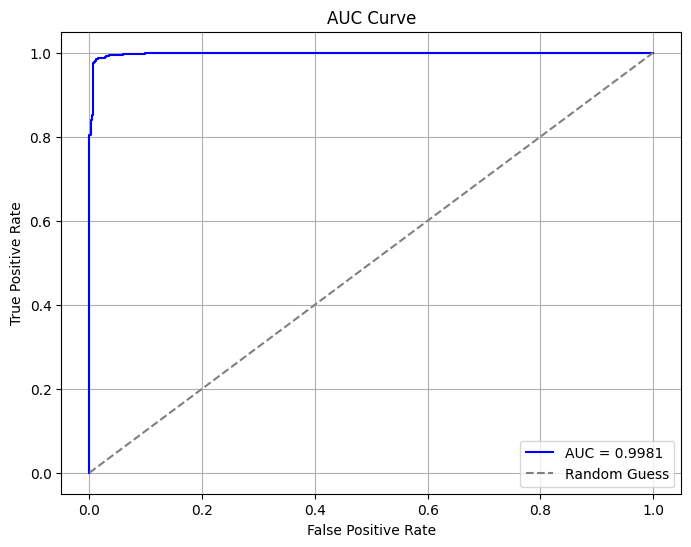

In [17]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_val_resampled.ravel(), best_clf.predict_proba(X_val_resampled)[:, 1])

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('Results/baseline_auc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## Persist the Best Model to Disk
Serialise (`joblib.dump`) the best‑performing model to a `.pkl` file so it can be loaded later for inference or further tuning.

In [11]:
import joblib

model_path = os.path.join(os.curdir, 'models', f'best_baseline_model_{best_name}.h5')
joblib.dump(best_clf, model_path)
print(f'Saved {best_name} to →  {model_path}')

Saved LogisticRegression to →  .\models\best_baseline_model_LogisticRegression.h5


## Evaluation on Test Set

In [12]:
import pandas as pd
if not os.path.exists("Results"):
    os.makedirs("Results")
# Load original test data (raw text)
TEST_DATA_PATH = os.path.join(DATA_ROOT, 'Depression_Tweets')
test_data = pd.read_json(os.path.join(TEST_DATA_PATH, 'depression_json'))
print(f"Number of records: {len(test_data)}")

Number of records: 18679


In [13]:
y_pred_test = best_clf.predict(X_test.reshape(len(X_test), -1))
print(f"Shape of y_pred_test: {y_pred_test.shape}")

Shape of y_pred_test: (18679,)


In [14]:
import json
# Prepare results in the desired format
results = []
for idx, (text, label) in enumerate(zip(test_data['content'], y_pred_test)):
    results.append({
        "id": idx,
        "predicted_label": int(label),
        "raw_text": text
    })

# Define the output file path
output_file_path = os.path.join("Results", "Result_baseline_logistic_regression.jsonl")

# Save the results to a JSONL file
with open(output_file_path, "w") as jsonl_file:
    for record in results:
        jsonl_file.write(json.dumps(record) + "\n")

print(f"Results saved to {output_file_path}")


Results saved to Results\Result_baseline_logistic_regression.jsonl
